In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
%matplotlib notebook

In [40]:
def convert_nan(string):
    try:
        i = float(string)
        return i 
    except ValueError:
        #Handle the exception
        return np.NaN
    
    
        
        
data = pd.read_csv('Assignment-2_gene_data.csv',converters={'S2':convert_nan,'S13':convert_nan})

In [41]:
data.head()

,Unnamed: 0,symbol,S1,S2,S3,S4,S5,S6,S7,S8,...,S21,S22,S23,S24,S25,S26,S27,S28,S29,S30
0,1,Zzz3,253.401685,402.850878,230.957463,688.486264,358.067836,344.962350,441.155001,301.149694,...,507.882774,465.081486,415.478767,297.061149,488.848114,367.912141,307.199908,347.802509,411.227261,283.709694
1,2,Zzef1,21.152797,21.152797,21.152797,21.152797,21.152797,21.152797,21.152797,21.152797,...,21.152797,21.152797,21.152797,21.152797,21.152797,21.152797,21.152797,21.152797,21.152797,21.152797
2,3,Zyx,40.578958,49.235160,59.472005,46.212152,61.969671,55.732843,53.819870,54.315691,...,33.512262,36.751853,36.952457,35.718610,27.346198,32.647887,42.006833,32.324596,41.426033,32.754971
3,4,Zyg11b,26.373102,35.001901,32.389728,34.932372,35.192365,33.858459,27.948378,21.152797,...,21.152797,21.152797,21.152797,21.152797,21.152797,21.152797,21.152797,21.152797,21.152797,21.152797
4,5,Zyg11a,21.152797,21.152797,21.152797,21.152797,21.152797,21.152797,21.152797,21.152797,...,21.152797,21.152797,21.152797,21.152797,21.152797,21.152797,21.152797,21.152797,21.152797,21.152797


In [42]:
data = data.dropna()

In [43]:
print(data.size)

717120


In [46]:
data = data.drop('Unnamed: 0',axis=1)
data = data.drop_duplicates()

In [47]:
print(data.size)

694214


In [48]:
data = data.set_index('symbol')

In [49]:
data = data.T
data = data.drop_duplicates()

In [50]:
print(data.size)

671820


In [51]:
data_pca = StandardScaler().fit_transform(data)

In [52]:
from sklearn.decomposition import PCA

In [53]:
pca = PCA(n_components=2)

In [54]:
pca_components = pd.DataFrame(pca.fit_transform(data_pca))

In [55]:
meta_data = pd.read_csv('Assignment-2 Meta data sheet .csv')

In [56]:
meta_data.head(2)

,sIdx,Time,Unit
0,S1,9,Hours
1,S2,9,Hours


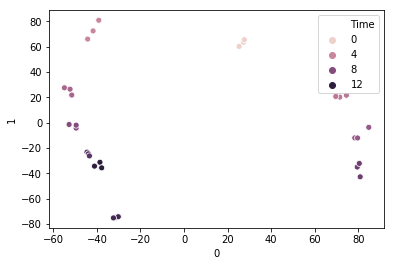

In [57]:
sns.scatterplot(x=pca_components[0],y=pca_components[1],hue=meta_data['Time'])